# Aplicacion RandomForest estratificado - 27 de noviembre

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define la ruta ABSOLUTA a la raíz de tu proyecto

project_root = "/Users/rocioperez/Documents/Projects/AFG/Git_Group_Project/eeg-prism" # MODIFIQUEN ESTE VALOR
project_root_path = Path(project_root)
# 2. Añade esta ruta al sys.path
if project_root not in sys.path:
    sys.path.append(str(project_root))

from src.data.utils import cat_p_factor, bin_p_factor # Usaremos esta funcion para clasificar p_factor

In [3]:
excel_path = Path("/Users/rocioperez/Documents/Projects/AFG/Git_Group_Project/eeg-prism/data/Medidas_TF.xlsx")
subjetcs= Path("/Users/rocioperez/Documents/Projects/AFG/Git_Group_Project/eeg-prism/data/subjects/subject_data.csv")
df = pd.read_excel(excel_path)
sub_df = pd.read_csv(subjetcs)

Eliminamos el prefijo 'sub-'

In [4]:
df = df.rename(columns={'Unnamed: 0': 'subject'})
df['subject'] = df['subject'].str.replace('sub-', '', regex=False)

In [5]:
merged_df = pd.merge(df, sub_df, on='subject', how='left')

df = merged_df
df = df.drop(columns=['restingstate', 'full_pheno', 'commercial_use', 'Unnamed: 0', 'release_number'])
df.head()


,subject,Fp1_TBR_open,Fp1_TBR_closed,Fp2_TBR_open,Fp2_TBR_closed,F3_TBR_open,F3_TBR_closed,F4_TBR_open,F4_TBR_closed,F7_TBR_open,...,F4-F3_FAA_closed,F8-F7_FAA_open,F8-F7_FAA_closed,sex,age,ehq_total,p_factor,attention,internalizing,externalizing
0,NDARAC904DMU,7.085008,7.044962,12.803920,6.111662,10.529524,10.196242,15.677175,4.483037,4.298716,...,-0.188146,-0.278317,1.810463,F,11.3386,71.17,-0.603,-0.446,1.248,0.325
1,NDARAG143ARJ,22.079352,14.207213,15.703567,8.839879,27.874811,14.155392,21.006711,11.662198,23.173019,...,-0.470526,-0.457478,-1.285867,M,7.6648,100.05,-0.258,-0.425,1.006,0.509
2,NDARAM704GKZ,6.786049,5.116421,4.230339,3.511600,6.008616,6.856234,4.438220,4.770484,7.507947,...,-0.005468,0.369402,0.328583,M,10.9449,-53.36,0.062,-0.119,0.222,0.366
3,NDARAN385MDH,20.967885,15.953953,12.380888,8.365515,18.097405,21.339423,12.081794,7.747585,18.007364,...,-0.036810,0.076245,-0.989952,M,10.7089,96.72,0.034,-0.308,0.455,-0.483
4,NDARAP359UM6,3.836128,3.912036,2.050058,2.141755,3.354355,4.809086,2.011176,3.062913,2.915773,...,-0.125673,-0.613229,-0.581397,F,12.8422,80.04,0.467,1.826,1.949,-0.926


## EDA

## Random Forest

### Sacar/Transformar variables

In [6]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna().copy()

In [7]:
df['sex'] = df['sex'].map({'M': 1, 'F': 0})

In [8]:
df['p_factor_cat'] = cat_p_factor(df)

### Train-Test

In [9]:
X_all = df.drop(columns=['subject', 'p_factor', 'p_factor_cat'])

In [10]:
y = df['p_factor_cat']
y = y.astype('category')

Nos preocupamos de estratificar Y para evitar el propblema de las clases desbalanceadas

In [11]:
from sklearn.model_selection import train_test_split

X_all_train, X_all_test, y_train, y_test = train_test_split(
    X_all, y, test_size=0.3, random_state=42, stratify=y
)

## Training

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf_all = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

rf_all.fit(X_all_train, y_train)

,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Modelo reducido

In [13]:
df.columns

Index(['subject', 'Fp1_TBR_open', 'Fp1_TBR_closed', 'Fp2_TBR_open',
       'Fp2_TBR_closed', 'F3_TBR_open', 'F3_TBR_closed', 'F4_TBR_open',
       'F4_TBR_closed', 'F7_TBR_open', 'F7_TBR_closed', 'F8_TBR_open',
       'F8_TBR_closed', 'C3_TBR_open', 'C3_TBR_closed', 'C4_TBR_open',
       'C4_TBR_closed', 'Fp2-Fp1_FAA_open', 'Fp2-Fp1_FAA_closed',
       'F4-F3_FAA_open', 'F4-F3_FAA_closed', 'F8-F7_FAA_open',
       'F8-F7_FAA_closed', 'sex', 'age', 'ehq_total', 'p_factor', 'attention',
       'internalizing', 'externalizing', 'p_factor_cat'],
      dtype='object')

In [23]:
cols_to_drop = [
    'sex', 'age',
    'ehq_total', 'attention',
    'internalizing', 'externalizing'
]

X_reduced = X_all.drop(columns=cols_to_drop)

In [24]:
X_red_train, X_red_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.3, random_state=42, stratify=y
)

In [25]:
rf_red = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

rf_red.fit(X_red_train, y_train)

,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Evaluacion

### Metricas modelo completo

In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred_all = rf_all.predict(X_all_test)

print("Accuracy:", accuracy_score(y_test, y_pred_all))
print("\nClassification report:\n", classification_report(y_test, y_pred_all))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred_all))

Accuracy: 0.6734104046242775

Classification report:
               precision    recall  f1-score   support

           0       0.68      0.99      0.80       235
           1       0.00      0.00      0.00        52
           2       0.00      0.00      0.00        59

    accuracy                           0.67       346
   macro avg       0.23      0.33      0.27       346
weighted avg       0.46      0.67      0.55       346


Confusion matrix:
 [[233   0   2]
 [ 52   0   0]
 [ 59   0   0]]


/Users/rocioperez/Documents/Projects/AFG/Git_Group_Project/eeg-prism/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rocioperez/Documents/Projects/AFG/Git_Group_Project/eeg-prism/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rocioperez/Documents/Projects/AFG/Git_Group_Project/eeg-prism/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with 

In [27]:
importances = rf_all.feature_importances_
feature_names = X_all.columns

sorted_idx = np.argsort(importances)[::-1]

for i in sorted_idx[:15]:  # top 15
    print(feature_names[i], ":", importances[i])

externalizing : 0.05813182525558327
internalizing : 0.05736559914454002
F8-F7_FAA_closed : 0.04146064114763089
age : 0.04139806666297853
F4-F3_FAA_open : 0.03907139109839714
attention : 0.03850853540473425
F8-F7_FAA_open : 0.03776640007365148
F4-F3_FAA_closed : 0.03684836082045421
Fp1_TBR_open : 0.036190328765853264
Fp2-Fp1_FAA_open : 0.036145956908327184
Fp2_TBR_closed : 0.0354355941229283
F3_TBR_closed : 0.03524655464723581
F4_TBR_closed : 0.03523517846294683
F3_TBR_open : 0.03492640830463732
C4_TBR_open : 0.034501999897013504


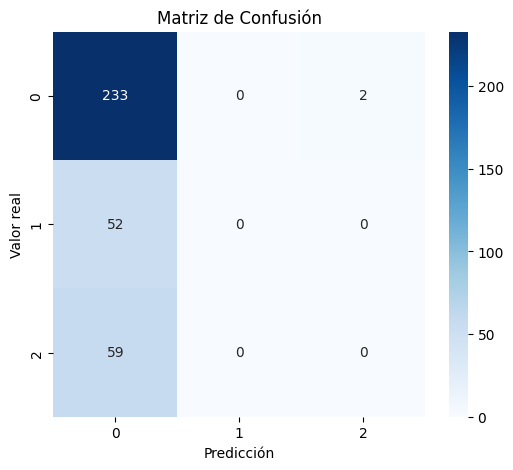

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_all)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=rf_all.classes_,
            yticklabels=rf_all.classes_)

plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de Confusión")
plt.show()

### Metricas modelo reducido

In [29]:
y_pred_red = rf_red.predict(X_red_test)

print("Accuracy (modelo reducido):", accuracy_score(y_test, y_pred_red))
print("\nClassification report (modelo reducido):\n",
      classification_report(y_test, y_pred_red))

Accuracy (modelo reducido): 0.6791907514450867

Classification report (modelo reducido):
               precision    recall  f1-score   support

           0       0.68      1.00      0.81       235
           1       0.00      0.00      0.00        52
           2       0.00      0.00      0.00        59

    accuracy                           0.68       346
   macro avg       0.23      0.33      0.27       346
weighted avg       0.46      0.68      0.55       346



/Users/rocioperez/Documents/Projects/AFG/Git_Group_Project/eeg-prism/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rocioperez/Documents/Projects/AFG/Git_Group_Project/eeg-prism/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rocioperez/Documents/Projects/AFG/Git_Group_Project/eeg-prism/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with 

In [30]:
importances = rf_red.feature_importances_
feature_names = X_reduced.columns

sorted_idx = np.argsort(importances)[::-1]

for i in sorted_idx[:15]:  # top 15
    print(feature_names[i], ":", importances[i])

F8-F7_FAA_closed : 0.05363251373241631
F8-F7_FAA_open : 0.04748208501688508
F4-F3_FAA_open : 0.04721839900256788
F3_TBR_closed : 0.04712963611109375
C3_TBR_closed : 0.04697998404515207
Fp1_TBR_open : 0.04664885268310341
F4-F3_FAA_closed : 0.04642329923232987
F4_TBR_closed : 0.046404160664012054
Fp2-Fp1_FAA_open : 0.046140447344364004
F3_TBR_open : 0.04586767941678585
Fp2_TBR_closed : 0.04507541347079581
C3_TBR_open : 0.04498717247004334
Fp2_TBR_open : 0.04477256263418048
F4_TBR_open : 0.04434422833784197
F7_TBR_open : 0.04408887425145519


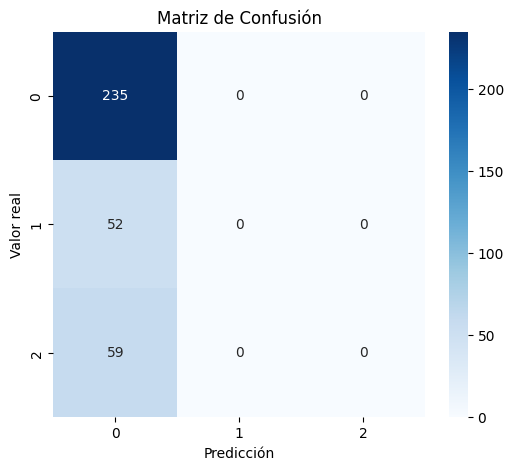

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_red)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=rf_all.classes_,
            yticklabels=rf_all.classes_)

plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de Confusión")
plt.show()